In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cmx
from mssm.models import *
from mssm.src.python.compare import compare_CDL
from mssmViz.plot import *
from mssmViz.sim import *
from mssmViz.extract import *
np.set_printoptions(suppress=True)

nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]
single_size = 8/2.54

# `mssm` Tutorial

With `mssm` we can estimate a broad variety of Generalized additive models as they are also supported in `mgcv` (Wood, 2017). Smooths that are available in mgcv and are also supported here include regular univariate smooths, binary smooth terms, Tensor smooth interactions, by-factor smooths, and random non-linear smooths. `mssm` also supports random effects (random intercepts, random slopes, and as mentioned random smooths).

A B-spline basis is used by `mssm` and penalties are either difference (Eilers & Marx, 2010) or identity penalties (Kernel penalties, Marra & Wood (2012) are also supported). Currently, Binomial models (N >= 1), Gamma models, and Gaussian models are supported! `mssm` uses sparse matrices and is thus particularly suited to handle models of **multi-level data, including many random effects**!

`mssm` automatically figures out the right amount of penalization for all terms using a combination of the approaches discussed by Wood & Fasiolo (2017) in "A generalized Fellner-Schall method for smoothing parameter optimization with application to Tweedie location, scale and shape models." and by Wood, Shaddick, & Augustin, (2017). "Generalized Additive Models for Gigadata: Modeling the U.K. Black Smoke Network Daily Data."

This tutorial contains the following:

- a brief discussion of the structure your data should have
- a TLDR if you are familiar with `mgcv` and GAMMs in general and just want to get started
- an extensive section of example Gaussian additive models so that you can get familiar with the different terms supported by `mssm`
- examples on how to estimate Generalized additive models and even more general models (i.e., Generalized additive models of location, scale, and shape)

In addition, this tutorial introduces the plot functions available in `mssmViz`, which can be used to visualize model predictions and to asses model validity via residual plots for all models estimated by `mssm`. This tutorial assumes that you are already familiar with the idea behind GAMMS (and perhaps even GAMMLSS models; Rigby & Stasinopoulos, 2005) and does not aim to provivde a thorough introduction to their theory. Instead, the aim is to show how to fit, inspect, and validate these models with `mssm`. If you want to learn more about the theory behind GAMMS (and GAMMLSS models), head to the reference section at the end of the tutorial, which contains pointers to papers and books focused on GAMM & GAMMLSS models.

## Data structure

In [2]:
# Import some simulated data
dat = pd.read_csv("./data/GAMM/sim_dat.csv")

# mssm requires that the data-type for variables used as factors is 'O'=object
dat = dat.astype({'series': 'O',
                  'cond':'O',
                  'sub':'O',
                  'series':'O'})

Some remarks about the desired layout of the data to be usable with the GAMM class:

- Data has to be provided in a `pandas.DataFrame`.
- The dependent variable can contain NAs, which will be taken care of. **No NAs should be present in any of the predictor columns**!
- The data-type (dtype) for numeric columns should be float or int. Categorical predictors need to have the object datatype (see code above).
- No specific row/column sorting is required.

**Exception to the last point:**

If you want to approximate the computations for random smooth models of multi-level time-series data that include a single smooth per unique time-series collected to speed up computation (see section on advanced topics), **the data should be ordered according to series, time**: the ordered (increasing) time-series corresponding to the first series should make up the first X rows. The ordered time-series corresponding to the next series should make up the next Y rows, and so on. More specifically, what matters is that individual series are making up a time-ordered sub-block of dat. So you could also have a dataframe that starts with a series labeled 0, then a series labeled 115, then a series labeled X. As long as the ordered time-series from series 0 is not interrupted by rows corresponding to any other series it will be fine.

In [3]:
# Take a look at the data:
dat.head()

,y,time,series,cond,sub,x
0,7.005558,0,0,a,0,9.817736
1,11.122316,20,0,a,0,10.262371
2,4.766720,40,0,a,0,10.445887
3,2.952046,60,0,a,0,8.481554
4,7.463034,80,0,a,0,10.180660


In [4]:
# To make sure the last point raised above is met - we can call the following.
# This does not hurt, even if we do not want to rely on approximate computations.
dat = dat.sort_values(['series', 'time'], ascending=[True, True])

### Factor Variable Coding

``mssm`` will automatically dummy-code levels of categorical variables (alphabetically/numerically ascending): the variable "cond" has two levels: "a" and "b". Internally, "a" will be set to the reference level (0), while "b" will be set to level 1.

If the coding should be fixed to a specific order, a `codebook` can be provided as keyword argument to any ``Formula``. A `codebook` is a dictionary containing dictionaries as values. The keys for the `codebook` need to refer to categorical variables in the data-frame. The value for each key is itself again a dictionary with a key for every level of the categorical variable specified as key, every level should then receive as value an integer from 0-k, where k is the number of levels of the categorical variable to which this dictionary belongs.
Not all variables have to be specified. For example, for fixing the ordering of "cond" the following `codebook` could be used:

``codebook = {'cond':{'a': 0, 'b': 1}}``

You can always extract the final `codebook` used by a model by calling `formula.get_factor_codings()` - where `formula` was the `Formula` specified for the model of interest.


**Important:**

If only the products involving the model matrix are to be formed (see "Very big random effect structure + MANY observations" example in the advanced topic section), the default level ordering may not reflect an alphabetical order. To ensure that this is the case, specify the `codebook` as described above.

## From `mgcv` to `mssm` - TLDR

Below we provide an overview of popular models in `mgcv` and how they can be represented in `mssm`. Together with the examples in the docstrings and those presented in the later sections of this tutorial, you should be able to get started in no time!

| mcgv    | mssm |
| -------- | ------- |
| `bam(y ~ s(x,k=10) + s(z,k=20))`  |  `GAMM(Formula(lhs("y"),[i(),f(["x"],nk=9),f(["z"],nk=19)]),Gaussian())` |
| `bam(y ~ cond + s(x,k=10,by=cond))`  |  `GAMM(Formula(lhs("y"),[i(),l(["cond"]),f(["x"],nk=9,by="cond")]),Gaussian())` |
| `bam(y ~ cond + s(x,k=10,by=cond,id=1))`  |  `GAMM(Formula(lhs("y"),[i(),l(["cond"]),f(["x"],nk=9,by="cond",id=1)]),Gaussian())` |
| `bam(y ~ te(x,z,k=10))`  |  `GAMM(Formula(lhs("y"),[i(),f(["x","z"],nk=9,te=True)]),Gaussian())` |
| `bam(y ~ s(x,k=10) + s(z,k=20) + ti(x,z,k=10))`  |  `GAMM(Formula(lhs("y"),[i(),f(["x"],nk=9),f(["z"],nk=19),f(["x","z"],nk=9,te=False)]),Gaussian())` |

Assuming that `cond` is a factor with two-levels ("a" and "b"), then setting up a **binary smooth** model in `mgcv` in R requires creating variable `dat$is_a <- ifelse(as.character(dat$cond)=="a", 1, 0)`. In `mssm` no extra variable needs to be created for such a simple model (see table below). More complex binary smooth models in `mssm` might however require setting up additional variables. For the models below we further assume that "sub" identifies a categorical/factor variable.

| mcgv    | mssm |
| -------- | ------- |
| `bam(y ~ s(x,k=10) + s(x,by=is_a))`  |  `GAMM(Formula(lhs("y"),[i(),f(["x"],nk=9),f(["x"],binary=["cond","a"])]),Gaussian())` |
| `bam(y ~ s(x,k=10) + s(sub,bs="re"))`  |  `GAMM(Formula(lhs("y"),[i(),f(["x"],nk=9),ri("sub")]),Gaussian())` |
| `bam(y ~ s(x,k=10) + s(sub,bs="re") + s(x,sub,bs="re"))`  |  `GAMM(Formula(lhs("y"),[i(),f(["x"],nk=9),ri("sub"),rs(["x"],rf="sub")]),Gaussian())` |
| `bam(y ~ s(x,k=10) + s(x,sub,bs="fs"))`  |  `GAMM(Formula(lhs("y"),[i(),f(["x"],nk=9),fs(["x"],rf="sub")]),Gaussian())` |
| `bam(y ~ s(x,k=10) + s(x,sub,by=cond,bs="fs"))`  |  `GAMM(Formula(lhs("y"),[i(),f(["x"],nk=9),*[fs(["x"],rf="sub",sub_group=["cond",c]) for c in ["a","b"]]]),Gaussian())` |


To estimate a non-normal GAMM, all that is necessary in `mssm` is to replace the `Gaussian()` with any other family supported by `mssm` (`Binomial()`, `Gamma()`). All families come with default choices for the link functions (see the doc strings for the different families for details). The `Binomial()` family assumes that whatever variable is specified as DV (e.g., "y" in the examples here) - holds **observed proportions** (of course this will be just 0s and 1s for binary data).

We will now discuss Gaussian example models in more detail. At the end of the section we also have some examples on how to estimate GAMMLSS models in `mssm`.

## Estimating Additive Models

### A single smooth model

In this section, we will focus exclusively on Gaussian GAMMs (or AMMs) to become familiar with the different smooth & parametric terms that we can incorporate in these models. In brief, the assumption underlying a GAMM is that each of our $N$ observations $y_i$ is a realizations from a random variable $Y_i \sim N(\mu_i,\sigma)$. We further assume that all the $Y_i$ are mutually independent! $\mu_i$ - the mean of each RV distribution - is modeled as an additive combination of smooth functions and parametric terms (the "additive model part"). In contrast to $\mu_i$ which can differ between $Y_i$, $\sigma$ is assumed to be shared by all RVs! For a more extensive introduction, we reccomed consulting the book by Simon Wood (2017, *Generalized Additive Models: An Introduction with R*).

We will now start with a simple model of the mean $\mu_i$, incorporating only a single smooth of time!

In [5]:
# Build a simple GAMM
# Y_i = a + f(time) + e with e ~ N(0,sigma)
formula = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time"])], # The f(time) term, by default parameterized with 9 basis functions (after absorbing one for identifiability)
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:1443: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [6]:
# Initialize the GAMM as a Gaussian one!
model = GAMM(formula,Gaussian())

In [7]:
# Some info about the size of this model:
print(f"Model will estimate {model.formula.get_n_coef()} coefficients from {len(model.formula.get_depvar()[model.formula.get_notNA()])} datapoints!")

Model will estimate 10 coefficients from 29217 datapoints!


In [8]:
# Fit the model
model.fit()

NAs were excluded for fitting.


Converged!:   0%|          | 0/50 [00:00<?, ?it/s]                


In [9]:
# We can print a summary of the smooth terms included in the model
# and the estimated degrees of freedom corresponding to each:
model.print_smooth_terms() # The single smooth term has used approximately 8.72 basis functions (of the 9 it could use).

f(['time']; edf: 8.723


In [10]:
# To get the total degrees of freedom used by the model we can access the ``edf`` argument:
round(model.edf,ndigits=3)

9.723

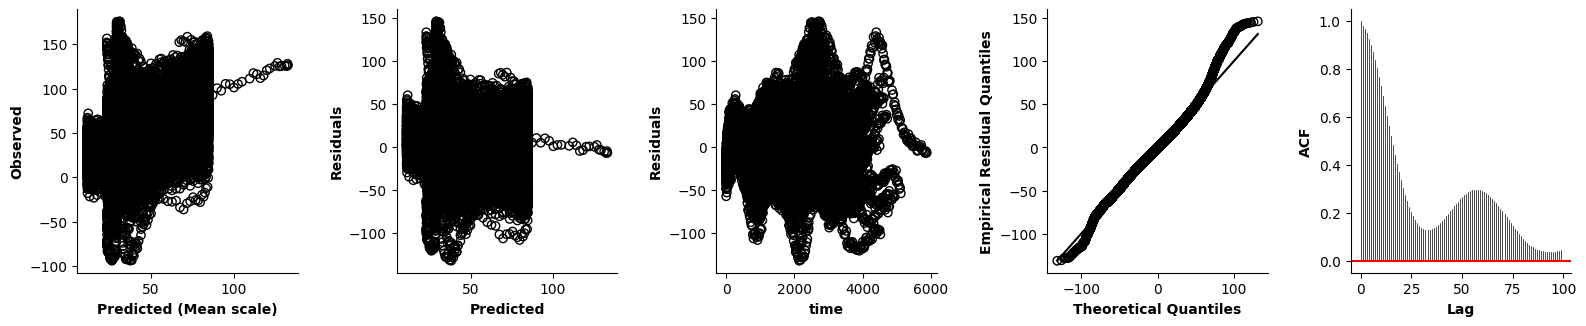

In [11]:
# Validation of the assumptions sketched out earlier is absolutely crucial.
# For the additive model, the independence of Y_1, Y_2, ... Y_N implies that
# the N-dimensional residual vector (the difference between the observed values y_i
# and the model predictions \mu_i) should looks like what could be expected from drawing
# N independent samples from N(0,sigma). This is best checked in residual plots as generated by
# `plot_val`. Clearly, this model fails to meet the assumptions - we will get back to that later!!
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(model,pred_viz=["time"],axs=axs)
plt.show()

In [12]:
# Of course mssm offers all information visualized in the plots above as attributes/via method calls, so that
# you can also make your own plots. Here some examples:

coef, sigma = model.get_pars() # Coef = weights for basis functions, sigma = **variance** of residuals!
pred = model.pred # The model prediction for the entire data, here: a + f(Time)!
mu = model.family.link.fi(pred) # The predicted mean - this will be identical to pred for the additive model, but this will not be the case for generalized additive models!
res = model.get_resid() # The residuals y_i - \mu_i
y = model.formula.y_flat[model.formula.NOT_NA_flat] # The dependent variable after NAs were removed

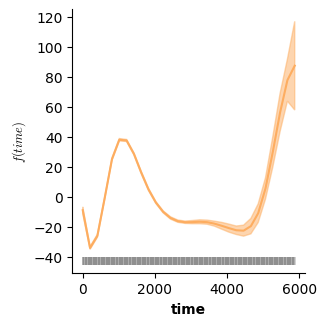

In [13]:
# Plot partial prediction for a single smooth
plot(model,fig_size=(single_size,single_size))

### A by-condition GAM

To get a by-factor model (s(Time,by=cond) in `mgcv`) `mssm` also provides a by keyword!

In [14]:
# Y = a + b1*c1 + f0(time) + f1(time) + e
# with e ~ N(0,sigma) and c1 == 1 if cond == "b" else 0
# and f0() and f1() representing the smooths over time for
# the first (a) and second (b) level of cond respectively.
formula2 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # One coefficient per dummy-predictor necessary for factor cond - here b
                               f(["time"],by="cond")], # One f(time) term for every level of cond
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:1443: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [15]:
# Fit the model
model2 = GAMM(formula2,Gaussian())
model2.fit()

NAs were excluded for fitting.


Converged!:   0%|          | 0/50 [00:00<?, ?it/s]                


In [16]:
# Again, we print a summary of the edf. per term in the model.
# Note: separate smooths were estimated for each level of "cond" so two edf values are printed.
model2.print_smooth_terms()

f(['time'],by=cond): a; edf: 6.881
f(['time'],by=cond): b; edf: 8.714


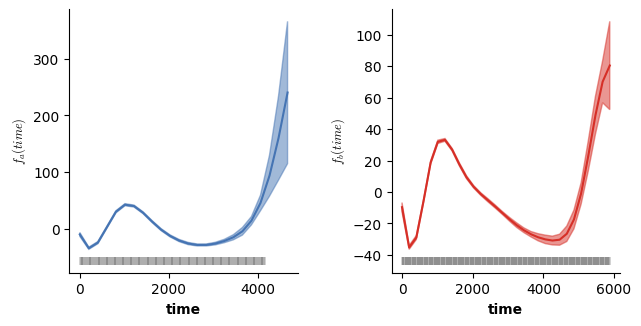

In [17]:
# Partial prediction (using only the f(time)) for all conditions
# Basically what plot(model) does in R in case model was obtained from mgcv
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(model2,axs=axs)
plt.show()

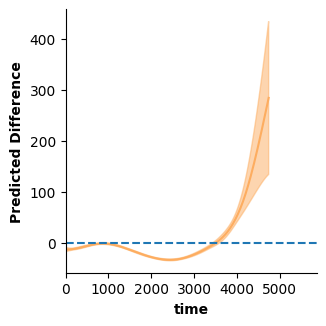

In [18]:
# Difference predictions between two conditions!
# `plot_diff` allows us to plot the predicted difference over time between conditions a and b.
# Note that `plot_diff` does by default take into account all terms included in the model,
# so the offset differences induced by a and b1 are taken into account!!
# Check the doc string if you want to know more!
# To access doc-strings, simply print function.__doc__:
# print(plot_diff.__doc__)

time_pred = [t for t in range(0,max(dat["time"]),20)]
new_dat1 = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                         "time":time_pred})

new_dat2 = pd.DataFrame({"cond":["b" for _ in range(len(time_pred))],
                         "time":time_pred})

# Note, by default `plot_diff` excludes predictor ranges for which one of the two conditions
# contains no values (time > 4000 only exists in cond b). This behavior can be changed with
# the `plot_exist` keyword.
fig = plt.figure(figsize=(single_size,single_size),layout='constrained')
ax = fig.subplots(1,1)
plot_diff(new_dat1,new_dat2,["time"],model2,ax=ax)
ax.axhline(0,linestyle='dashed')
plt.show()

### A binary smooth model

If the difference between conditions is of interest it might be more desirable to fit a difference curve for specific levels of the factor of interest, rather than plotting the predicted difference. This can be beneficial in case conditions differ in the values of the predictor over which the difference is to be evaluated, because confidence intervals will often be narrower.

We set up such a model below!

In [19]:
formula3 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time"]), # One f(time) term - will correspond to the baseline level for condition: here let's choose b
                               f(["time"],binary=["cond","a"])], # Another f(time), this one models the difference over time from the other f(time) term for cond=a!
                        data=dat)

In [20]:
# Fit the model
model3 = GAMM(formula3,Gaussian())
model3.fit()
model3.print_smooth_terms()

NAs were excluded for fitting.


Converged!:   0%|          | 0/50 [00:00<?, ?it/s]                

f(['time']; edf: 8.72
f(['time'],by=a); edf: 6.693


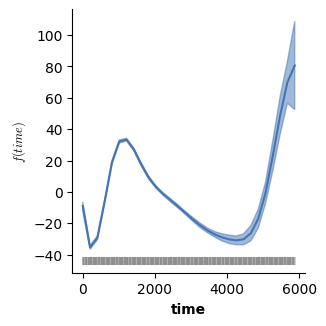

In [21]:
# Let's look at just the f(time) for level b - this one looks just like before!
plot(model3,which=[1],fig_size=(single_size,single_size),prov_cols=0.1)

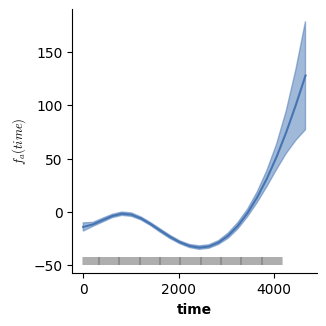

In [22]:
# However, just the prediction from the second f(time) does look a bit different
# now! In fact it represents the difference between the two conditions!
plot(model3,which=[2],fig_size=(single_size,single_size))

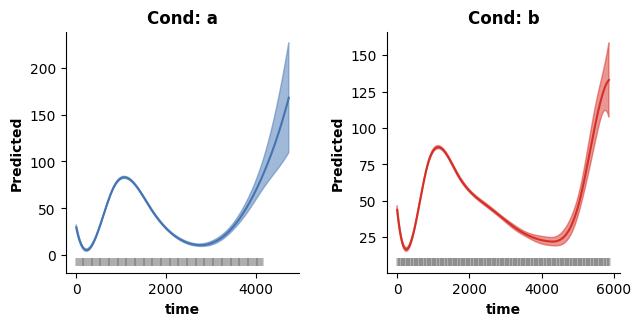

In [23]:
# If we use all terms we can still predict how y changes over time for both conditions! For this
# we make use of the `plot_fitted` function, which allows to visualize the combined prediction of
# multiple terms included in the model (again, see the doc string!)
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
cols = [0.1,0.9]
titles = ["Cond: a", "Cond: b"]

for ci,c in enumerate(["a","b"]):
    # Set up some new data for prediction
    time_pred = [t for t in range(0,max(dat["time"]),20)]
    
    new_dat = pd.DataFrame({"cond":[c for _ in range(len(time_pred))],
                            "time":time_pred})
    
    plot_fitted(new_dat,["time"],model3,ax=axs[ci],col=cols[ci],use=[0,1,2],title=titles[ci])
    
plt.show()

### Tensor smooth interactions

Non-linear interactions between continuous variables are supported via tensor smooth interactions (see Wood, 2006. *Low‐Rank Scale‐Invariant Tensor Product Smooths for Generalized Additive Mixed Models* and Wood, 2017). Both the behavior achieved by the `ti()` and `te()` terms in `mgcv` is supported. Let's start with considering the `te()` term behavior!

In [24]:
formula4 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # Offset for cond='b'
                               f(["time","x"],by="cond",te=True)], # one smooth surface over time and x - f(time,x) - per level of cond: three-way interaction!
                        data=dat)

In [25]:
# Fit the model
model4 = GAMM(formula4,Gaussian())
model4.fit()

# We end up with two smooth terms - one surface for every level of cond.
model4.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  78%|███████▊  | 39/50 [00:09<00:02,  4.20it/s]                

f(['time', 'x'],by=cond): a; edf: 12.69
f(['time', 'x'],by=cond): b; edf: 19.142


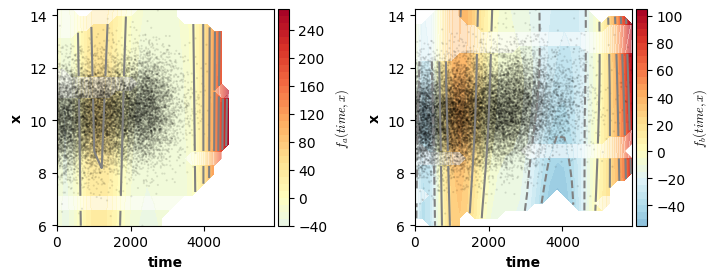

In [26]:
# Visualizing the partial interaction. By default predictor combinations for which at least one value
# exceeds the extrema of the predictor present in the data used to estimate the model are not visualized
# (e.g., time < 4000 for condition a, so the surface for time values > 4000 remains blank). In addition,
# a rug plot of all predictor combinations actually present in the data is layed over the function. This
# behavior can be changed by the `plot_exist` and `te_exist_style` arguments - check the doc string!
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
plot(model4,axs=axs)
plt.show()

The ti() term in mgcv enables decomposing the 3-way interaction into separate interaction (including lower order interactions) and main effects! In ``mssm`` this is achieved by omitting the ``te=True`` argument (the default). In that case, separate smooth terms have to be included for the lower order interactions, just like in `mgcv`:

In [27]:
formula5 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # Offset for cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond")], # one smooth surface over time and x - f(time,x) - per level of cond: three-way interaction!
                        data=dat)

In [28]:
# Fit the model
model5 = GAMM(formula5,Gaussian())
model5.fit()

# We end up with a total of 6 smooth terms in this model!
model5.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  70%|███████   | 35/50 [00:14<00:06,  2.42it/s]                

f(['time'],by=cond): a; edf: 6.88
f(['time'],by=cond): b; edf: 8.715
f(['x'],by=cond): a; edf: 1.015
f(['x'],by=cond): b; edf: 1.0
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 4.41


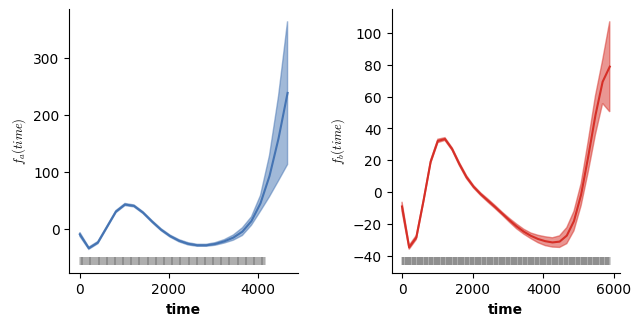

In [29]:
# Visualizing the partial main effects of time.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(model5,which=[2],axs=axs,ci=True)
plt.show()

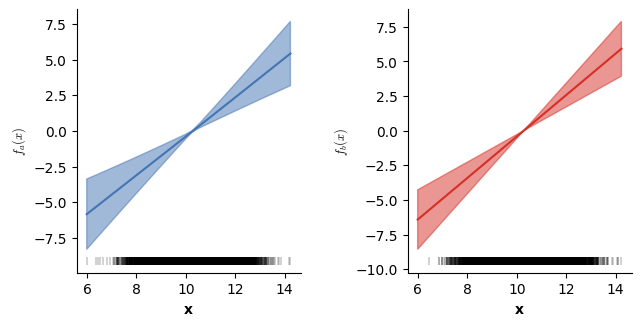

In [30]:
# Visualizing the partial main effects of x.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(model5,which=[3],axs=axs,ci=True)
plt.show()

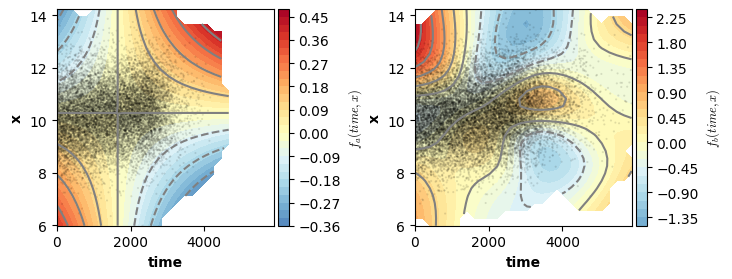

In [31]:
# Visualizing the partial interaction. Now the surface really covers only the three-way interaction estimate. Hence, it looks very different from the previous plots.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
plot(model5,which=[4],axs=axs,ci=False)
plt.show()

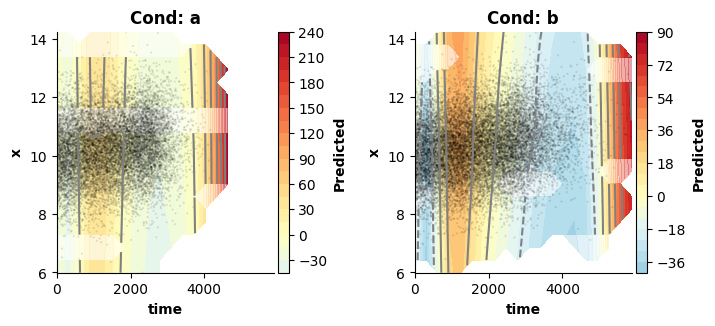

In [32]:
# Visualizing the three-way interaction + the two-way interactions approximates the surfaces estimated by model4, which did not attempt to decompose these.
# In this case, the plots are quite similar. This is not guaranteed, and in practice models set up like model5 will tend to produce more flexible solutions - because they have
# a larger solution space, in which they might find evidence for a more complex solution (see Wood, 2017).

fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
titles = ["Cond: a", "Cond: b"]

# Set up some new data for prediction
time_pred = []
x_pred = []

xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),20)]
tr = np.linspace(0,max(dat["time"]),len(xr))

for t in tr:
    for x in xr:
        time_pred.append(t)
        x_pred.append(x)

# Loop over conditions
for ci,c in enumerate(["a","b"]):
    

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred})
    
    plot_fitted(new_dat,["time","x"],model5,ax=axs[ci],use=[2,3,4],title=titles[ci])
    
plt.show()

### Binary tensor smooth interactions
The binary smooth approach generalizes beyond the univariate case to the tensor smooth interaction case. Essentially, we then fit a smooth surface for the reference level and difference surfaces for the remaining levels of a factor. Such a model is set up below.

In [33]:
formula6 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time","x"],te=True), # one smooth surface over time and x - f(time,x) - for the reference level = cond == b
                               f(["time","x"],te=True,binary=["cond","a"])], # another smooth surface over time and x - f(time,x) - representing the difference from the other surface when cond==a
                        data=dat)

In [34]:
# Fit the model
model6 = GAMM(formula6,Gaussian())
model6.fit()

# We again end up with two smooth terms in the model.
model6.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  82%|████████▏ | 41/50 [00:11<00:02,  3.65it/s]                

f(['time', 'x']; edf: 16.636
f(['time', 'x'],by=a); edf: 12.205


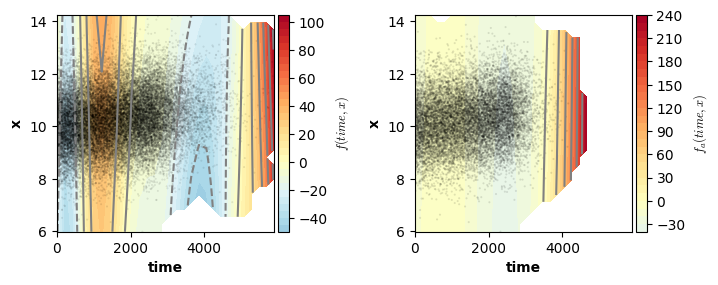

In [35]:
# Visualizing the two surfaces reveals the same picture visibile for the univariate case: the left surface largely matches the surface estimated by
# model 4! The right surface is now the difference surface estimated for condition a!
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
plot(model6,which=[1],axs=[axs[0]],ci=False)
plot(model6,which=[2],axs=[axs[1]],ci=False)
plt.show()

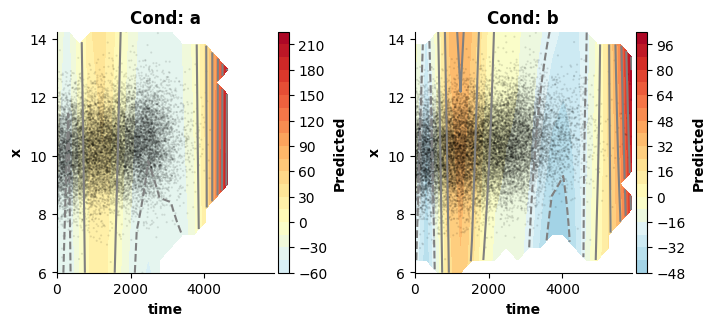

In [36]:
# Hence, to recover the actual surfaces for both conditions we need to add them together when cond == "a"
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
titles = ["Cond: a", "Cond: b"]

# Set up some new data for prediction
time_pred = []
x_pred = []

xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),20)]
tr = np.linspace(0,max(dat["time"]),len(xr))

for t in tr:
    for x in xr:
        time_pred.append(t)
        x_pred.append(x)

# Loop over conditions
for ci,c in enumerate(["a","b"]):
    

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred})
    
    plot_fitted(new_dat,["time","x"],model6,ax=axs[ci],use=[1,2],title=titles[ci],ci=False)
    
plt.show()

### Random effects
We can also include random intercepts, random slopes, and non-linear random smooths into any `mssm` model!

#### Random Intercepts

To model a random intercept (e.g., per subject or item), simply add an `ri` term:

In [37]:
formula7a = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               ri("sub")], # Random intercept for each subject
                        data=dat)

In [38]:
# Fit the model
model7a = GAMM(formula7a,Gaussian())
model7a.fit()
model7a.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  50%|█████     | 25/50 [00:13<00:13,  1.87it/s]                

f(['time'],by=cond): a; edf: 6.906
f(['time'],by=cond): b; edf: 8.753
f(['x'],by=cond): a; edf: 1.0
f(['x'],by=cond): b; edf: 1.06
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.009
ri(sub); edf: 18.966063215179695


In [39]:
# You can extract the estimated random intercepts using the ``get_term_coef`` function, which returns the
# coefficients associated with a specific term in the formula (here term 5, corresponding to the random intercept term)
rand_int = get_term_coef(model7a,[5])
print(rand_int)

[-22.41791476  16.5850011  -21.77296273  -0.97033966   4.1297982
 -14.47430913  -3.79707236  10.31508858  -4.72341537 -13.64913087
   2.08051507   0.80421241   8.99108794  21.95927343 -16.1184062
  32.35952743  13.12601167   0.96067904  19.1084719  -32.49611568]


#### Random Slopes

Many different random slope combinations are possible - but they are all achieved with the `rs` term. Check the doc-string for the `rs` term for different examples. Below
we estimate a random intercept per subject (achieved with the `ri` term) and also a random slope of time (achieved with the `rs` term) - with a separate variance parameter per condition:

In [40]:
formula7b = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               ri("sub"), # Random intercept for each subject
                               rs(["time","cond"],rf="sub")], # Random slope of time for subject - separate ones for each level of cond
                        data=dat)

In [41]:
# Fit the model
model7b = GAMM(formula7b,Gaussian())
model7b.fit()
model7b.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  24%|██▍       | 12/50 [00:06<00:20,  1.83it/s]                

f(['time'],by=cond): a; edf: 6.912
f(['time'],by=cond): b; edf: 8.832
f(['x'],by=cond): a; edf: 1.222
f(['x'],by=cond): b; edf: 1.0
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.002
ri(sub); edf: 16.826483712618355
rs(['time', 'cond'],sub); edf: 18.868529860869764


In [42]:
# The ``get_term_coef`` function can again be used to obtain the estimated random slopes. Note, that
# the function returns a single array even though separate sets of random slopes were estimated per level of "cond":
# The first 20 (here "sub" had 20 levels, i.e., there were 20 subjects) elements in this array will correspond to the
# random slopes estimated for the first level of "cond", the next 20 to the second level, and so on. To check which
# level of "cond" was treated as the "first level" you can inspect the codebook again, via ``formula.get_factor_codings()``
rand_slopes = get_term_coef(model7b,[6])
print(rand_slopes)

[-0.01378245  0.00819604 -0.01639945  0.00134047  0.00236797 -0.00987685
 -0.00505919  0.00416012 -0.00253616 -0.00645524 -0.00138625  0.00397987
  0.00591231  0.01360001 -0.00873344  0.02268764  0.00823901 -0.002043
  0.012414   -0.0166254  -0.01538739  0.00677377 -0.01116884 -0.00030926
 -0.00042274 -0.00985929 -0.0007393   0.00418148  0.00048126 -0.00270049
 -0.00091574  0.0059529   0.00683666  0.01346553 -0.00899865  0.02012658
  0.00682334 -0.00621479  0.01245048 -0.02037552]


#### Random Smooths

GAMMs also allow to decompose the mean into a non-linear fixed part and a non-linear random part - e.g., a general smooth trend over time and factor-level-specific non-linear deviations from it. Additive models estimate the latter as **random smooth terms**:

In [43]:
formula7c = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               fs(["time"],rf="sub")], # Random smooth for each subject
                        data=dat)

In [44]:
# Fit the model
model7c = GAMM(formula7c,Gaussian())
model7c.fit()
model7c.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  18%|█▊        | 9/50 [00:04<00:20,  1.96it/s]                

f(['time'],by=cond): a; edf: 6.892
f(['time'],by=cond): b; edf: 8.635
f(['x'],by=cond): a; edf: 1.209
f(['x'],by=cond): b; edf: 1.0
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.112
f(['time'],by=sub); edf: 131.86


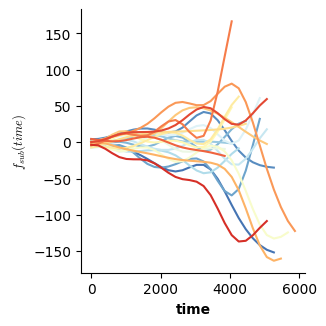

In [45]:
# Subject difference smooths - is there a subject-specific difference from the general trend?
plot(model7c,which=[5],fig_size=(single_size,single_size))

In the R-package `mgcv` it is common to estimate random smooth terms with separate smoothing penalties for different levels of an additional experimental factor (e.g., cond). In `mssm` this is achieved with the following syntax:

In [46]:
# First we have to create a factor in our data that separates subjects between different levels (i.e., the interaction of the factor cond and sub):
dat["sub_cond"] = dat["cond"].astype(str) + dat["sub"].astype(str)

In [47]:
# Now we can specify the formula:
formula7d = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               fs(["time"],rf="sub_cond",by_subgroup=["cond","a"]), # Random smooth for each subject for group a of factor cond
                               fs(["time"],rf="sub_cond",by_subgroup=["cond","b"])], # Random smooth for each subject for group b of factor cond
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:1443: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [48]:
# Fit the model
model7d = GAMM(formula7d,Gaussian())
model7d.fit()
model7d.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  50%|█████     | 25/50 [00:25<00:25,  1.01s/it]                

f(['time'],by=cond): a; edf: 6.894
f(['time'],by=cond): b; edf: 8.523
f(['x'],by=cond): a; edf: 1.07
f(['x'],by=cond): b; edf: 1.055
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.039
f(['time'],by=sub_cond): a; edf: 87.001
f(['time'],by=sub_cond): b; edf: 134.415


#### Sparse Alternative to random smooths

The model below is similar to model 7c. The non-linear random effect is built differently here, and the estimate looks different as well. This model is a bit more storage efficient so if that is a concern it might be worth considering using this parameterization. It is however more difficult to estimate..

In [49]:
formula8 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               f(["time"],by="sub",id=1,identifiable=False,penalty=[PenType.DIFFERENCE,PenType.IDENTITY],pen_kwargs=[{"m":1},{}],nk=10)], # Random non-linear effect of time - one smooth per level of factor sub
                        data=dat)

In [50]:
# Fit the model
model8 = GAMM(formula8,Gaussian())
model8.fit()
model8.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  92%|█████████▏| 46/50 [00:25<00:02,  1.81it/s]                

f(['time'],by=cond): a; edf: 6.876
f(['time'],by=cond): b; edf: 8.601
f(['x'],by=cond): a; edf: 1.179
f(['x'],by=cond): b; edf: 1.0
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.0
f(['time'],by=sub); edf: 131.007


### Very big random effect models

`mssm` is particularly well suited to fit big random effect structures. The model below estimates a non-linear random smooth of time for every individual series in the dataframe.

In [51]:
len(np.unique(dat["series"])) # 200 non-linear curves will be estimated by the random effect.

200

In [52]:
formula9 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",nk=20), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

In [53]:
# Fit the model
model9 = GAMM(formula9,Gaussian())
model9.fit()
model9.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  52%|█████▏    | 26/50 [01:28<01:21,  3.40s/it]                

f(['time'],by=cond): a; edf: 12.377
f(['time'],by=cond): b; edf: 17.605
f(['x'],by=cond): a; edf: 1.258
f(['x'],by=cond): b; edf: 1.567
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 8.526
f(['time'],by=series); edf: 2372.124


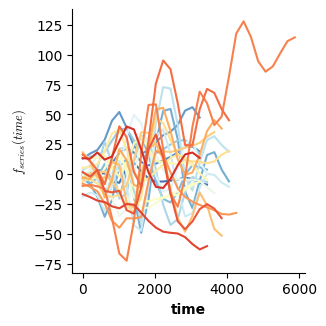

In [54]:
# Series difference smooths - is there a series-specific difference from the general trend?
plot(model9,which=[5],fig_size=(single_size,single_size))

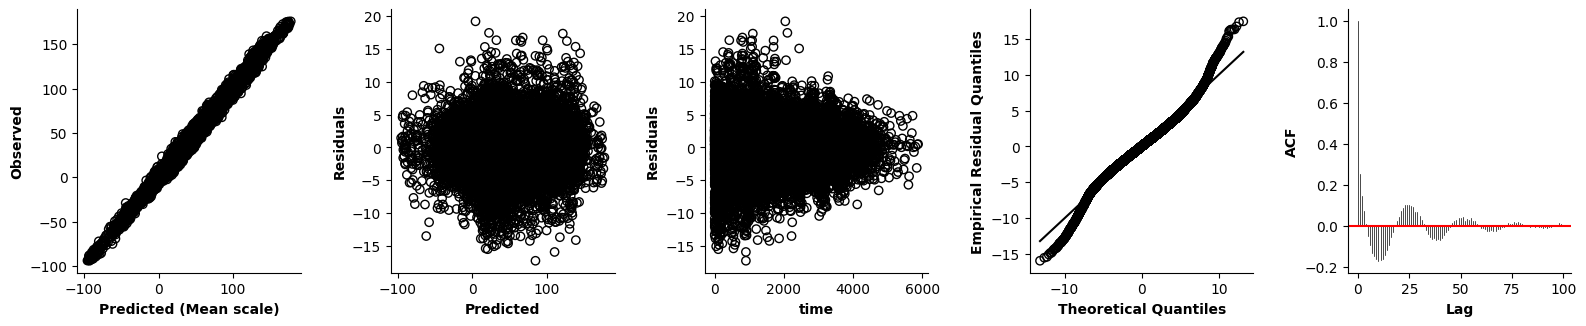

In [55]:
# This model finally achieves reasonable model fit - meeting the model assumptions.
# Note that when modeling multi-level neuro-physiological time-series data in particular it will usually be
# necessary to have trial-level random effect terms to ensure that the assumptions can be
# met.
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(model9,pred_viz=["time"],axs=axs)
plt.show()

## Advanced topics

### Model selection

`mssm` supports penalty-based model selection (Marra & Wood, 2011; *Practical variable selection for generalized additive models*). In practice, that means the models can penalize entire terms out of the model (they become ~ equal to zero over their covariate(s)). To enable this, provide the ``penalize_null=True`` argument to splines for which this should be enabled (Note: to maximize efficiency, it might be a good idea to only apply this to terms that are close to the edf that could be expected from a function in the kernel of their penalty).

In [56]:
formula10 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",nk=20), # two-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond",penalize_null=True), # two-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond",penalize_null=True), # three-way interaction
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

In [57]:
# Fit the model
model10 = GAMM(formula10,Gaussian())
model10.fit()
model10.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  34%|███▍      | 17/50 [00:36<01:10,  2.13s/it]                

f(['time'],by=cond): a; edf: 12.377
f(['time'],by=cond): b; edf: 17.605
f(['x'],by=cond): a; edf: 1.464
f(['x'],by=cond): b; edf: 1.521
f(['time', 'x'],by=cond): a; edf: 0.0 *
f(['time', 'x'],by=cond): b; edf: 7.194
f(['time'],by=series); edf: 2372.13

One term has been effectively penalized to zero and is marked with a '*'


A non-linear two-way interaction between `time` and `x` is only supported for condition `b` (since the edf for the two-way interaction for condition `a` are close to 0). This actually supports the three-way interaction.

This is also supported by confidence intervals for the two-way interaction: The confidence interval for the two-way interaction for condition `a` contains zero for every `x` and `time` combination. For condition `b`, the interval does not contain zero for some `time` & `x` combinations (see plot below).

This would imply, that the model should not be simplified further.



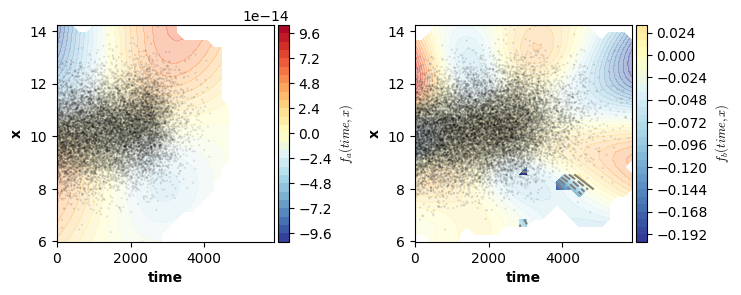

In [58]:
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
plot(model10,which=[4],axs=axs,ci=True)
plt.show()

We can also use an approximate GLRT or AIC (see Wood 2017) to compare the model to a nested simpler model, to check whether the reduction in complexity leads to a drastically worse fit.

**Note, the GLRT should not be combined with penalty-based selection. Hence, model 10 needs to be re-estimated without an extra Kernel penalty.**

In [59]:
formula10 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",nk=20), # two-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # two-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

formula11 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",nk=20), # two-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # two-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"]), # two-way interaction between x and time
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

In [60]:
# Fit the models
model10 = GAMM(formula10,Gaussian())
model10.fit()
model10.print_smooth_terms()

model11 = GAMM(formula11,Gaussian())
model11.fit()
model11.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  52%|█████▏    | 26/50 [01:31<01:24,  3.53s/it]                


f(['time'],by=cond): a; edf: 12.377
f(['time'],by=cond): b; edf: 17.605
f(['x'],by=cond): a; edf: 1.258
f(['x'],by=cond): b; edf: 1.567
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 8.526
f(['time'],by=series); edf: 2372.124
NAs were excluded for fitting.


Converged!:  34%|███▍      | 17/50 [00:30<00:58,  1.77s/it]                

f(['time'],by=cond): a; edf: 12.377
f(['time'],by=cond): b; edf: 17.607
f(['x'],by=cond): a; edf: 1.321
f(['x'],by=cond): b; edf: 1.504
f(['time', 'x']; edf: 3.188
f(['time'],by=series); edf: 2372.082


In [61]:
CDL_res = compare_CDL(model10,model11,alpha=0.05,correct_V=False)
print(f"Accepting alternative hypothesis that the two-way interaction between time and x actually differs between cond levels? {CDL_res['H1'] == 1}")
print(f"Probability of observing twice the difference in log-likelihood as extreme or more extreme than {CDL_res['chi^2']}\nunder the Null (interaction between time and x does not differ between cond levels): {CDL_res['p']}")
print(f"AIC difference between model 1 and model 2: {CDL_res['aic_diff']}")

Accepting alternative hypothesis that the two-way interaction between time and x actually differs between cond levels? True
Probability of observing twice the difference in log-likelihood as extreme or more extreme than 19.5893986709998
under the Null (interaction between time and x does not differ between cond levels): 0.01613052711683638
AIC difference between model 1 and model 2: -6.834433566546068


In this case the GLRT would also suggest that the three-way interaction contributes significantly to the model. Similarly, the negative AIC difference indicates that model 1, the one including the three-way interaction, provides a much better fit. Hence, model 10 is probably the better model. Importantly, the GLRT test and AIC criterion are both biased and not necessarily conservative enough - in particular when setting `correct_V=False` (see Wood, Pya, & Säfken; 2016). Smoothing Parameter and Model Selection for General Smooth Models.). In practice, it should always be set to `True`. See the doc-string for ``compare_CDL`` for more details and consult the references therein.

**In practice, the test should generally be combined with other evidence (i.e., based on null-penalty information or confidence intervals). p-values close to one's personal alpha level should be considered very carefully.**

### Very big random effect models

`mssm` can approximate the computations involved in determining the smoothness penalty for **trial/series-level** random smooth terms for Gaussian additive models. This can drastically speed up the time it takes to fit the model. Below, we demonstrate this by re-estimating model 9. Note, that the approximate model might differ slightly in terms of edf and fitted effects from the exact model.

Approximating computations requires specifying a discretization dictionary for each random smooth term for which computations should be approximate. The dictionary must implement **this structure**: `{"no_disc":[str],"excl":[str],"split_by":[str],"restarts":int}`:

- `no_disc` should usually be set to an empty list, and should in general only contain names of
continuous variables included in the formula. Any variable included in this list will not be discretized in advance. This can improve performance if continuous variables are included with less than 10 unique values. However, it also slows down the clustering that is performed as part of the approximation strategy.

- Similarly, `excl` specifies any continuous variables that should be **excluded** for clustering - this can speed up clustering quite a bit but the resulting model might differ more from the exact one because variables are essentially ignored for the computation. Hence, this should only be set to an non-empty list if you really know what you are doing.

- `split_by` should generally be set to a list containing all categorical variables present in the formula.

- `restarts` indicates the number of times to re-produce the clustering (should be set to at least 40). Increasing this number usually leads to better results - but the upfront computation cost is increased.

In [62]:
# Approximating computations requires specifying a discretization dictionary.
discretize = {"no_disc":[],"excl":[],"split_by":["cond"],"restarts":40}

formula12 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",nk=20), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               fs(["time"],rf="series",nk=20,approx_deriv=discretize)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat,
                        series_id="series") # When approximating the computations for a random smooth, the series identifier column needs to be specified!

/Users/joshmac/opt/anaconda3/envs/mssm_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Clustering: 100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


In [63]:
# Fit the model
model12 = GAMM(formula12,Gaussian())
model12.fit()
model12.print_smooth_terms()

NAs were excluded for fitting.


Converged!:  52%|█████▏    | 26/50 [00:45<00:42,  1.75s/it]                


f(['time'],by=cond): a; edf: 12.388
f(['time'],by=cond): b; edf: 17.616
f(['x'],by=cond): a; edf: 1.257
f(['x'],by=cond): b; edf: 1.566
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 8.513
f(['time'],by=series); edf: 2392.512


### Very big random effect models + MANY observations

In case a Gaussian model needs to be estimated with a big random effect structure and from more than 3-4 million observations, ``mssm`` can follow the strategy described in "Generalized additive models for large data sets" (Wood, Goude, and Shaw; 2015) to only build the products involving the model matrix once and to never accumulate the entire model matrix. This requires that the data-set is separated into multiple smaller .csv files (see the tutorials/data folder for an example split of the sim_dat.csv) - which ``mssm`` will process in parallel to accumulate the products involving the model matrix.

At every iteration the model predictions need to be obtained which requires the product of a row-block of the model matrix and the current estimate of the coefficient vector. ``mssm`` either needs to re-compute the row-block for each prediction or can rely on caching to read it from a drive. For extremely big models (> 20 million observations) the latter can be substantially faster (depending on the system's hardware). By default caching is disabled. To enable it the ``mssm.src.python.gamm_solvers.SHOULD_CACHE`` variable should be set to True. The ``mssm.src.python.gamm_solvers.CACHE_DIR`` variable determines the relative location (default "./.db") of the cache directory. The directory will be deleted after estimation (if running the model fails, the directory might persist - ``mssm`` will require the user to manually delete the directory in that case).

Below we re-estimate model 10 (with the extra Kernel penalties) using this iterative building strategy. In terms of fit and edf both models should be viertually identical.

In [64]:
# Note: Categorical variables need to be stored in a way that makes it obvious to pandas that they are not numeric.
# The code below shows how the data for this example were split

if False:
    for cond in np.unique(dat["cond"]):
        cond_dat = dat.loc[dat["cond"] == cond,:]
        cond_dat.loc[:,"series"] = "series_" + cond_dat["series"].astype(str)
        cond_dat.loc[:,"sub"] = "sub_" + cond_dat["sub"].astype(str)
            
        cond_dat.to_csv(f"./data/GAMM/sim_dat_cond_{cond}.csv",index=False,header=True)

In [65]:
# Now we just collect the paths to the split files and pass those to the formula.
file_paths = [f"./data/GAMM/sim_dat_cond_{cond}.csv" for cond in ["a","b"]]

In [66]:
import mssm as mssm

# Disable caching (default)
mssm.src.python.gamm_solvers.SHOULD_CACHE = False

# Ensure ordering matches the one enforced automatically for model11.
codebook = {'cond':{'a': 0, 'b': 1}}

formula13 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond",nk=20), # two-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond",penalize_null=True), # two-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond",penalize_null=True), # three-way interaction
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=None, # No data frame!
                        file_paths=file_paths, # Just a list with paths to files.
                        print_warn=False,
                        keep_cov=False, # Re-read and encode all data from file at every iteration - further reducing memory footprint, but can slow down if reading takes long
                        codebook=codebook,
                        file_loading_nc = 10) # Set number of cores used for building X.TX in parallel!

In [67]:
# Fit the model
model13 = GAMM(formula13,Gaussian())
model13.fit()
model13.print_smooth_terms()

Converged!:  34%|███▍      | 17/50 [01:32<02:58,  5.42s/it]                

f(['time'],by=cond): a; edf: 12.377
f(['time'],by=cond): b; edf: 17.605
f(['x'],by=cond): a; edf: 1.464
f(['x'],by=cond): b; edf: 1.521
f(['time', 'x'],by=cond): a; edf: 0.0 *
f(['time', 'x'],by=cond): b; edf: 7.194
f(['time'],by=series); edf: 2372.13

One term has been effectively penalized to zero and is marked with a '*'


### Posterior Simulation & Whole-interval CIs

In the section on model selection we briefly dicussed CIs, and that they offer an additional tool to check whether a function should be included in the model or not. Importantly, the CIs visualized so far are point-wise CIs, but to determine whether a function should be included in the model at all, whole-function CIs are more appropriate. Point-wise CIs include the true function on average at 95% of the values evaluated - but that rate might be higher or lower for some combination of predictor values over which the interval is evaluated (i.e., the coverage is truly achieved "on average"). Whole-function CIs on the other hand are modified to encapsulate the true function at every evaluated predictor combination with a certain probability (see Wood, 2017 but also Simpson, 2016 for more details) - i.e., they ensure that the entire true function falls within the CI boundaries with 95% certainty.

The difference can be visualized best by simulating from the conditional posterior distribution of a GAM(M). Wood (2017) shows that the latter is approximately $\beta | \lambda,y \sim N(\hat{\beta},\mathbf{V})$. Where $\mathbf{V}$ is the inverse of the ngeative Hessian of the penalized likelihood. By defining model-matrix $\hat{\mathbf{X}}$ to only contain non-zero entries in the columns related to some function of interest $f$, we can use this result to simulate replications of $f$:

In [68]:
# Set up some new data for prediction
tr = np.linspace(0,4000,30)

pred_dat = pd.DataFrame({"time":tr,
                        "x":[-1 for _ in range(len(tr))],
                        "cond":["a" for _ in range(len(tr))],
                        "series":[0 for _ in range(len(tr))]})

_,pred_mat,_ = model10.predict([2],pred_dat)

In [69]:
# `use_post` identifies only coefficients related to f(time) - and only for condition a
use_post = pred_mat.sum(axis=0) != 0
use_post = np.arange(0,pred_mat.shape[1])[use_post]
use_post

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21])

In [70]:
# Now we can sample new realizations of f(time) from the conditional posterior
# By default all plotting functions will draw 10.000 samples from the posterior so we specify this for the manual sampling below.
post = model10.sample_post(10000,use_post,seed=2000)
post_f = pred_mat[:,use_post] @ post

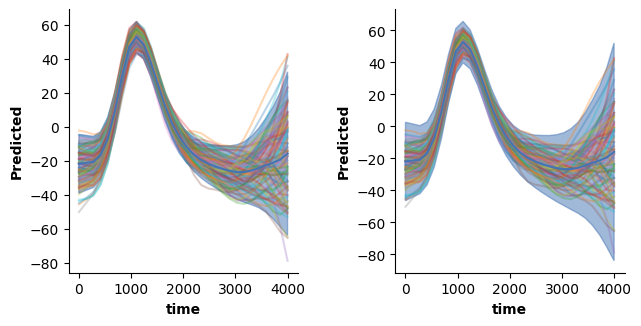

In [71]:
# And plot the replications against a point-wise and a whole-function CI
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})

for sim in range(100):
    axs[0].plot(pred_dat["time"],post_f[:,sim],alpha=0.3)

plot_fitted(pred_dat,["time"],model10,[2],ax=axs[0],plot_exist=False,col=0.1)

for sim in range(100):
    axs[1].plot(pred_dat["time"],post_f[:,sim],alpha=0.3)

# This time, we set the whole-interval argument to `True`.
plot_fitted(pred_dat,["time"],model10,[2],ax=axs[1],whole_interval=True,plot_exist=False,col=0.1)

plt.show()

Evidently, while the point-wise CI covers the simulated replications consistently over some time values, there are quite a few curves that do not fall within the CI boundaries *when considering the entire time range*. For the whole-function CI most replicate functions are *completely* encapsulated.

To clarify, the point-wise CI is **not** performing poorly here! In fact, the check below confirms that - *on average over time* - it contains simulated replicates in 95% across simulations. However, only in around 70% of simulations does it contain the function over the whole time range - but it was simply not designed to achieve this!

In [72]:
# Get the boundaries shown in the left plot and check them against each replicate function
# drawn from the posterior.
pred,pred_mat,b = model10.predict([2],pred_dat,whole_interval=False,seed=2000,ci=True)

avg = []
full_cov = 0
for pi in range(post_f.shape[1]):
    IN_CI = ((pred + b) > post_f[:,pi]) & ((pred - b) < post_f[:,pi])
    if not False in np.unique(IN_CI):
        full_cov += 1

    avg.append(len(pred[IN_CI])/len(pred))

full_cov/=post_f.shape[1]
print(np.mean(avg))
print(full_cov)

0.9502233333333333
0.6969


We can now run the same check for the whole-function CI. Note that for the check a different seed is used (otherwise coverage would be exactly 95%). Nevertheless, the whole-function CI covers the entire replicate in approximately 95% of simulations. In terms of average coverage it over-performs (naturally) - achieving a point-wise coverage of almost 99%. This is only logical, considering that the interval is simply expanded - relative to the point-wise CI.

In [73]:
# Get the boundaries shown in the right plot and check them against each replicate function
# drawn from the posterior.
pred,pred_mat,b = model10.predict([2],pred_dat,whole_interval=True,seed=1500,ci=True)

avg = []
full_cov = 0
for pi in range(post_f.shape[1]):
    IN_CI = ((pred + b) > post_f[:,pi]) & ((pred - b) < post_f[:,pi])
    if not False in np.unique(IN_CI):
        full_cov += 1

    avg.append(len(pred[IN_CI])/len(pred))

full_cov/=post_f.shape[1]
print(np.mean(avg))
print(full_cov)

0.9939733333333334
0.9483


This quick comparison highlights, that if you want to check whether a smooth has *any* effect, i.e., whether it should be included in the model, whole-function CIs are much more appropriate, simply because they test this more explicitly. That is: if the whole-function CI for a smooth contains zero at every evaluated predictor combination, it is probably safe to assume that the effect can be dropped from the model.

### Generalized Additive Models

So far, we have only considered additive models - assuming that our response variables $Y_i \sim N(\mu_i,\sigma)$, where $\mu_i$ is the model prediction for observation $y_i$ (i.e., realization of $Y_i$). A **Generalized** additive model allows to replace the normal distribution with $\mathcal{E}$ - denoting any member of the exponential family of distributions, so that $Y_i \sim \mathcal{E}(\mu_i,\phi)$. $\mu_i$ is usually modelled as a known (link) function $g(\mu_i)$ of the model prediction $\eta_i$ for observation $y_i$, assumed to be a realization from $Y_i$.


`mssm` currently supports Binomial ($\phi=1$) and Gamma models.

#### Gamma GAM

Below we simulate data for a Gamma Gam. We assume: $Y_i \sim \Gamma(\mu_i,\phi)$. The Gamma distribution is usually not expressed in terms of the mean and scale ($\phi$) parameter
but rather in terms of a shape and rate parameter - called $\alpha$ and $\beta$ respectively. Wood (2017) provides $\alpha = 1/\phi$. With this we can obtain $\beta = 1/\phi/\mu$ (see the doc-string for the `Gamma` family for details).

In [74]:
# Data for Gamma model looks just like for Gaussian..
Gammadat = sim3(500,2,family=Gamma(),seed=0)
print(Gammadat.head())

             y        x0        x1        x2        x3
0    12.379666  0.636962  0.081324  0.013008  0.048017
1  2060.005457  0.269787  0.875228  0.827763  0.656338
2  5235.301228  0.040974  0.941706  0.496243  0.011885
3    68.708860  0.016528  0.261864  0.435918  0.052403
4   366.684112  0.813270  0.012101  0.601795  0.023161


In [75]:
# Now we can specify the model.
gamma_formula = Formula(lhs("y"),[i(),f(["x0"]),f(["x1"]),f(["x2"]),f(["x3"])],data=Gammadat)

# By default, the Gamma family assumes that the model predictions match log(\mu_i), i.e., a log-link is used.
gamma_model = GAMM(gamma_formula,Gamma())
gamma_model.fit()

Converged!:  36%|███▌      | 18/50 [00:00<00:00, 128.83it/s]                


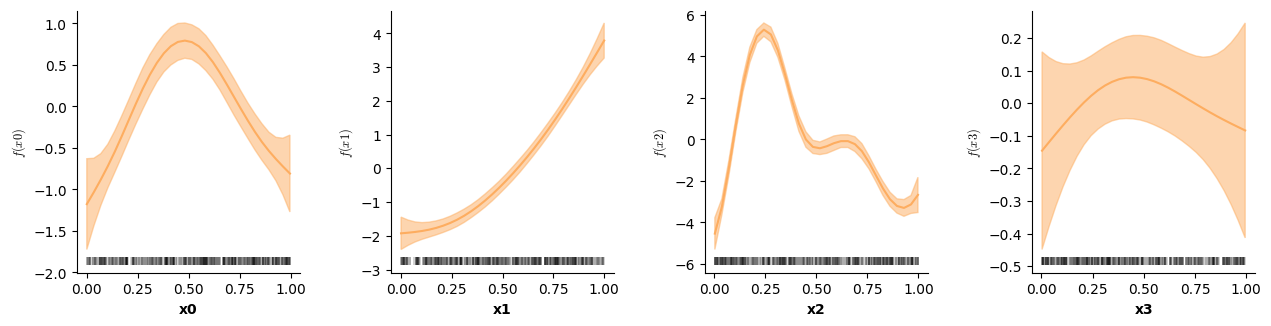

In [76]:
# Remember: by default the effects are plotted on the scale of the linear predictor - set the `response_scale=True` argument
# to make sure that plots are on the scale of the mean of the RVs.
fig = plt.figure(figsize=(4*single_size,single_size),layout='constrained')
axs = fig.subplots(1,4,gridspec_kw={"wspace":0.1})
plot(gamma_model,axs=axs,response_scale=False)
plt.show()

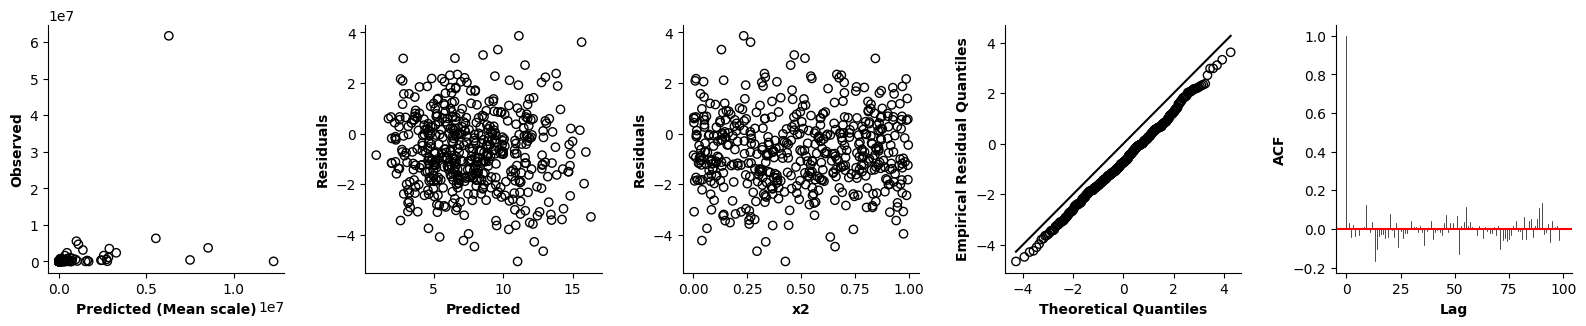

In [77]:
# Model validation remains just as crucial for GAMMS as it was for AMMS!
# We can check the model by inspecting standardized (deviance) residuals (see Wood, 2017 for details) - if the model
# is correctly specified, we can expect those to behave like N(0,\phi)!
# So the same plots remain relevant. Note that for Binomial models, we can really not expect the deviance residuals to be N(0,\phi) -
# but they should still be independent!
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(gamma_model,pred_viz=["x2"],resid_type="deviance",axs=axs)
plt.show()

### Binomial GAM

For the implementation of the `Binomial` family `mssm` assumes that we have collected proportions of success, i.e., the dependent variables specified in the model `Formula` needs to hold **observed proportions and not counts**!

If we assume that each observation $y_i$ reflects a single independent draw from a binomial, (with $n=1$, and $p_i$ being the probability that the result is 1) then the dependent variable should either hold 1 or 0. If we have multiple independent draws from the binomial per observation (i.e., row in our data-frame), then $n$ will usually differ between observations/rows in our data-frame (i.e., we observe $k_i$ counts of success out of $n_i$ draws - so that $y_i=k_i/n_i$). In that case, the `Binomial()` family accepts a vector for argument `n` (which is simply set to 1 by default, assuming binary data), containing $n_i$ for every observation $y_i$.

In [78]:
# Data for Binomial model assumes proportions as DV - for binary this will simply be 0s and 1s.
Binomdat = sim3(10000,2,family=Binomial())
print(Binomdat.head())
print(np.unique(Binomdat["y"],return_counts=True))

   y        x0        x1        x2        x3
0  0  0.079709  0.738515  0.801546  0.145329
1  1  0.540310  0.103962  0.834139  0.770857
2  0  0.602122  0.650488  0.544346  0.414565
3  1  0.263408  0.169704  0.483747  0.450269
4  1  0.168135  0.637269  0.958290  0.753665
(array([0, 1]), array([3041, 6959]))


In [79]:
# Now we can again specify the model.
binom_formula = Formula(lhs("y"),[i(),f(["x0"]),f(["x1"]),f(["x2"]),f(["x3"])],data=Binomdat)

# By default, the Binomial family assumes binary data and uses the logit link.
binom_model = GAMM(binom_formula,Binomial())
binom_model.fit()

Converged!:  16%|█▌        | 8/50 [00:00<00:02, 20.58it/s]                


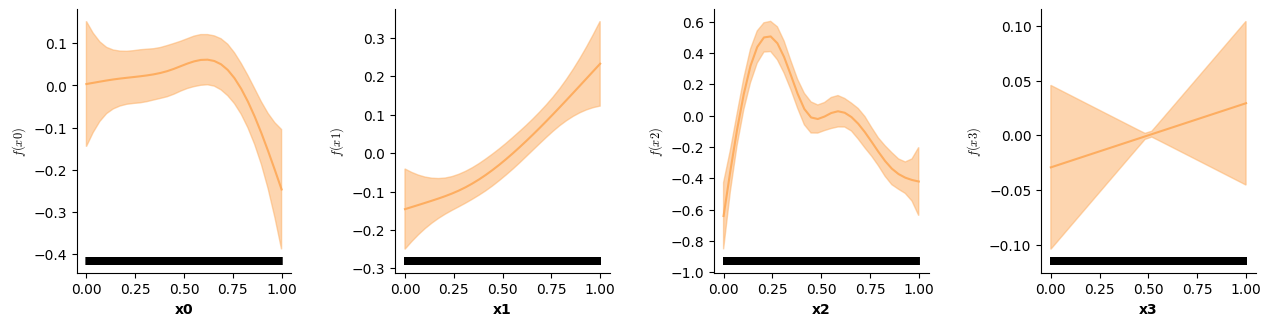

In [80]:
# Let's take a look at predictions on the scale of the log-odds
fig = plt.figure(figsize=(4*single_size,single_size),layout='constrained')
axs = fig.subplots(1,4,gridspec_kw={"wspace":0.1})
plot(binom_model,axs=axs,response_scale=False)
plt.show()

In [81]:
binom_model.print_smooth_terms()

f(['x0']; edf: 2.96
f(['x1']; edf: 1.773
f(['x2']; edf: 6.062
f(['x3']; edf: 1.0


### Generalized Additive Models of Location Scale and Shape


GAMMs are already more flexible than AMMS and come in handy if we cannot assume that the variance in our RVs $Y_i$ remains constant. However, they are still quite restrictive in that they restrict the variance to change according to a (often relatively simple) function of the mean of $Y_i$ and because they assume that the scale parameter and any other distribution parameter are shared between observations. 

The answer to these problems are Generalized Additive Models of Location, Scale and Shape (GAMMLSS models; Rigby & Stasinopoulos, 2005), in which we model all parameters of the distribution, not just the mean, as additive combinations of smooth functions and other parametric terms. That is, we assume $Y_i \sim \mathcal{E}(\mu_i,\phi_i,...,\tau_i)$ For example, in time-series modeling we might assume that our RVs are $Y_i \sim N(\mu_i,\sigma_i)$ - where both $\mu_i$ and $\sigma_i$ change smoothly as a function of time. Note, that this allows modeling very different patterns of heteroscedasticity - also those that might not easily be captured by modeling the variance as a simple function of the mean.

`mssm` currently supports Normal models ($\mu$ and $\sigma$ can be modelled), Gamma models ($\mu$ and $\phi$ can be modeled), and Multinomial models (Probability of $Y_i$ taking one one of $K$ values can be modelled).

#### Gaussian GAMMLSS

Below we simulate data for a Gaussian GAMMLSS model. Both the mean and the standard deviation of $Y_i$ change as a function of variable x0. Setting up a GAMMLSS model in `mssm` is not much more work than setting up a GAM. The main difference is that multiple formulas need to be provided - one per distributional parameter of the family.

In [82]:
# Simulate 1000 data points
GAUMLSSDat = sim6(1000)

# We need to model the mean: \mu_i = \alpha + f(x0)
formula_m = Formula(lhs("y"),
                    [i(),f(["x0"],nk=15)],
                     data=GAUMLSSDat)

# and the standard deviation as well: log(\sigma_i) = \alpha + f(x0)
formula_sd = Formula(lhs("y"),
                    [i(),f(["x0"],nk=15)],
                     data=GAUMLSSDat)

# Collect both formulas
formulas = [formula_m,formula_sd]

# Create Gaussian GAMMLSS family with identity link for mean
# and log link for sigma
family = GAUMLSS([Identity(),LOG()])

# Now define the model and fit!
gaumlss_model = GAMMLSS(formulas,family)
gaumlss_model.fit()

Converged!:  28%|██▊       | 14/50 [00:39<01:40,  2.79s/it]                


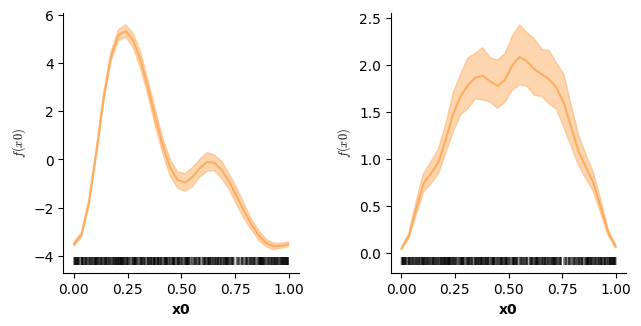

In [83]:
# Now we can visualize the estimated shape of f(x0) for both the mean and standard deviation parameter
# as well as approximate CIs for both.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(gaumlss_model,dist_par=0,response_scale=True,axs=[axs[0]])
plot(gaumlss_model,dist_par=1,response_scale=True,axs=[axs[1]])
plt.show()

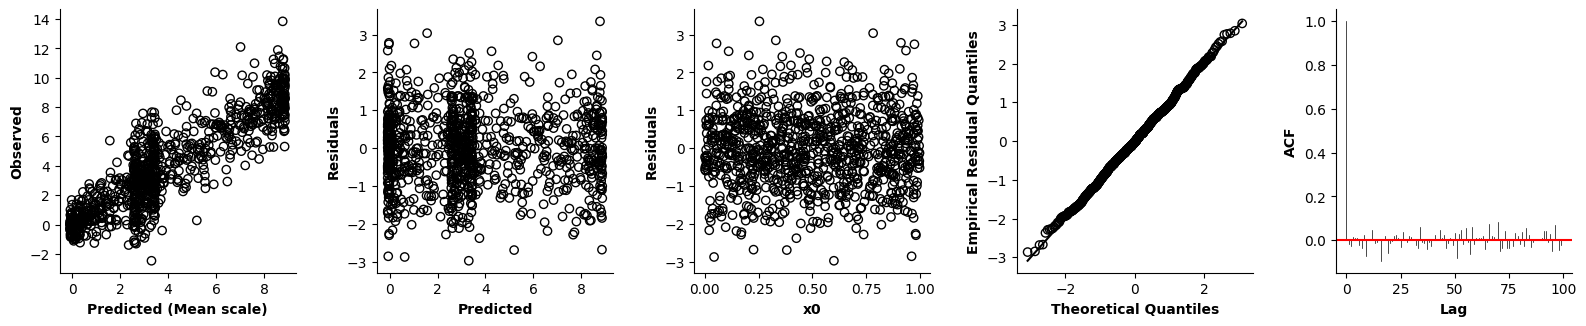

In [84]:
# Also for GAMMLSS models we need to check the validity of the model. Standaridzed residuals are
# plotted as well - these should be N(0,1) if the model is correct (see `plot_val` doc-string and Rigby & Stasinopoulos, 2005)!
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(gaumlss_model,pred_viz=["x0"],axs=axs)
plt.show()

#### GAMMA GAMMLSS

We now simulate the $Y_i$ with a Gamma distribution - both mean and scale parameter of the Gamma again vary as a function of x0.

In [85]:
# Simulate 1000 data points
GAMMALSSDat = sim6(1000,family=GAMMALS([LOG(),LOG()]))

# We need to model the mean: \mu_i = \alpha + f(x0)
formula_m = Formula(lhs("y"),
                    [i(),f(["x0"],nk=15)],
                     data=GAMMALSSDat)

# and the scale parameter as well: log(\scale_i) = \alpha + f(x0)
formula_sd = Formula(lhs("y"),
                    [i(),f(["x0"],nk=15)],
                     data=GAMMALSSDat)

# Collect both formulas
formulas = [formula_m,formula_sd]

# Create Gamma GAMMLSS family with log link for mean
# and log link for sigma
family = GAMMALS([LOG(),LOG()])

# Now define the model and fit!
gammalss_model = GAMMLSS(formulas,family)
gammalss_model.fit()

Converged!:  20%|██        | 10/50 [00:20<01:23,  2.08s/it]                


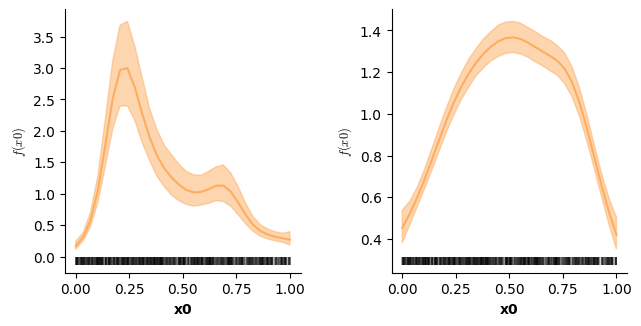

In [86]:
# Now we can visualize the estimated shape of f(x0) for both the mean and standard deviation parameter
# as well as approximate CIs for both.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(gammalss_model,dist_par=0,response_scale=True,axs=[axs[0]])
plot(gammalss_model,dist_par=1,response_scale=True,axs=[axs[1]])
plt.show()

#### Multinomial GAMMLSS

The final GAMMLSS example is for a multinomial model. This Family assumes that each observation $y_i$ corresponds to one of $K$ classes (labeled as 0,...,$K$) and reflects a
realization of an independent RV $Y_i$ with probability mass function defined over the $K$ classes. These K probabilities - that $Y_i$ takes on class 0,...,$K$ - are modeled as additive combinations of smooth functions of covariates and other parametric terms. This model can thus be used to perform multi-label classification!

Below we simulate for a Multinomial model with 5 classes - with the probability of $Y_i$ taking on any of these classes changing as a function of variable X0.

In [88]:
# Simulate data
MULNOMDAT = sim5(1000,seed=20)

# We need to specify K-1 formulas - see the `MULNOMLSS` docstring for details.
formulas = [Formula(lhs("y"),
                    [i(),f(["x0"],nk=10)],
                     data=MULNOMDAT) for k in range(4)]

# Create family - again specifying K-1 pars - here 4!
family = MULNOMLSS(4)

# Fit the model
model = GAMMLSS(formulas,family)
model.fit()

Converged!:  34%|███▍      | 17/50 [00:39<01:17,  2.34s/it]                


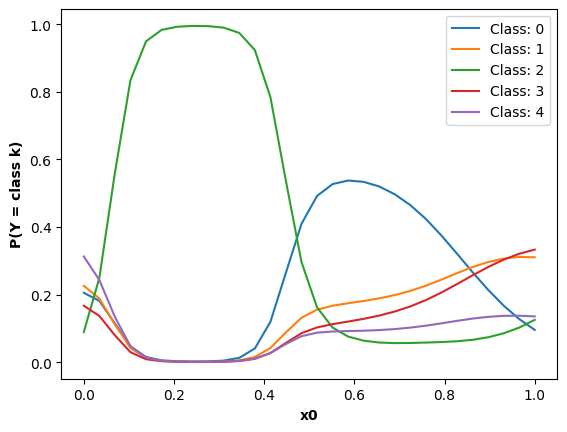

In [89]:
# Visualizing how the probability of Y_i taking on any of the K=5 values is a bit
# more complicated, which is why the `plot` functions won't work with Multinomial models. However,
# the code below outlines how to achieve this.

# First obtain the K-1 model predictions
pred_dat = pd.DataFrame({"x0":np.linspace(0,1,30)})
mus = []
upper_CIs = []
lower_CIs = []
for k in range(4):

    eta,_,b = model.predict(k,[0,1],pred_dat,ci=False,whole_interval=True)
    mu = family.links[k].fi(eta)
    mus.append(mu)

# These can now be transformed into the K class probabilities (see the MULNOMLSS methods doc-strings for details):
mu_last = np.sum(mus,axis=0) + 1
mus = [mu/mu_last for mu in mus]
mus.append(1/mu_last)

# Now we can plot the K class probabilities as a function of X0:
for k in range(5):
    plt.plot(pred_dat['x0'],mus[k],label=f"Class: {k}")
plt.legend()
plt.xlabel("x0",fontweight='bold')
plt.ylabel("P(Y = class k)",fontweight='bold')
plt.show()

## References

**B-Splines and Difference Penalty bases**:

- Eilers, P., & Marx, B. (1996). Flexible smoothing with B-splines and penalties. Statistical Science, 11(2), 89–121. https://doi.org/10.1214/ss/1038425655
- Eilers, P., & Marx, B. (2010). Splines, knots, and penalties. https://doi.org/10.1002/WICS.125

**GAMM Estimation as implemented by `mssm`**:

- Wood, S. N. (2006). Low‐Rank Scale‐Invariant Tensor Product Smooths for Generalized Additive Mixed Models. Biometrics, 62(4), 1025–1036. https://doi.org/10.1111/j.1541-0420.2006.00574.x
- Wood, S. N. (2011). Fast stable restricted maximum likelihood and marginal likelihood estimation of semiparametric generalized linear models: Estimation of Semiparametric Generalized Linear Models. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 73(1), 3–36. https://doi.org/10.1111/j.1467-9868.2010.00749.x
- Wood, S. N., Scheipl, F., & Faraway, J. J. (2013). Straightforward intermediate rank tensor product smoothing in mixed models. Statistics and Computing, 23(3), 341–360. https://doi.org/10.1007/s11222-012-9314-z
- Wood, S. N., Goude, Y., & Shaw, S. (2015). Generalized additive models for large data sets. Journal of the Royal Statistical Society: Series C (Applied Statistics), 64(1), 139–155. https://doi.org/10.1111/rssc.12068
- Wood, S. N., Li, Z., Shaddick, G., & Augustin, N. H. (2017). Generalized Additive Models for Gigadata: Modeling the U.K. Black Smoke Network Daily Data. Journal of the American Statistical Association, 112(519), 1199–1210. https://doi.org/10.1080/01621459.2016.1195744
- Wood, S. N., & Fasiolo, M. (2017). A generalized Fellner-Schall method for smoothing parameter optimization with application to Tweedie location, scale and shape models. Biometrics, 73(4), 1071–1081. https://doi.org/10.1111/biom.12666

**GAMMLSS Estimation as implemented by `mssm` & Smoothing penalty uncertainty**:

- Rigby, R. A., & Stasinopoulos, D. M. (2005). Generalized Additive Models for Location, Scale and Shape. Journal of the Royal Statistical Society Series C: Applied Statistics, 54(3), 507–554. https://doi.org/10.1111/j.1467-9876.2005.00510.x
- Wood, S. N., Pya, N., & Säfken, B. (2016). Smoothing Parameter and Model Selection for General Smooth Models. Journal of the American Statistical Association, 111(516), 1548–1563. https://doi.org/10.1080/01621459.2016.1180986


**Kernel penalties & Penalty-based model selection**:

- Marra, G., & Wood, S. N. (2011). Practical variable selection for generalized additive models. Computational Statistics & Data Analysis, 55(7), 2372–2387. https://doi.org/10.1016/j.csda.2011.02.004

**Whole-interval CIs**:

- Simpson, G. (2016). Simultaneous intervals for smooths revisited. Accessed at: https://fromthebottomoftheheap.net/2016/12/15/simultaneous-interval-revisited/

**GAMMS in general & Overview**:

- Wood, S. N. (2020). Inference and computation with generalized additive models and their extensions. TEST, 29(2), 307–339. https://doi.org/10.1007/s11749-020-00711-5
- Wood, S. N. (2017). Generalized Additive Models: An Introduction with R, Second Edition (2nd ed.). Chapman and Hall/CRC.